# Manufacturing Prescriptive Analytics
## Predictive Modeling & Parameter Optimization using Real Dataset

**Domain:** Manufacturing & Quality Control  
**Analytics Type:** Predictive + Prescriptive Analytics  
**Dataset:** UCI Milling Machine Dataset / NASA Tool Wear Dataset  
**Objective:** Build predictive models and optimize manufacturing parameters


## 1. Import Libraries

In [2]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.svm import SVC, SVR
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_recall_fscore_support, roc_auc_score, roc_curve,
    mean_squared_error, mean_absolute_error, r2_score
)

# XGBoost
import xgboost as xgb

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Optimization
from scipy.optimize import minimize, differential_evolution
import cvxpy as cp

# Model interpretation
import shap

# Utilities
import joblib
import requests
from io import StringIO

print("✅ All libraries imported successfully!")
print(f"TensorFlow: {tf.__version__}")
print(f"XGBoost: {xgb.__version__}")

✅ All libraries imported successfully!
TensorFlow: 2.19.0
XGBoost: 3.0.5


## 2. Load Real-World Manufacturing Dataset

### Dataset: AI4I 2020 Predictive Maintenance Dataset
**Source:** UCI Machine Learning Repository  
**Link:** https://archive.ics.uci.edu/ml/datasets/AI4I+2020+Predictive+Maintenance+Dataset  
**Size:** 10,000 data points  
**Features:** Temperature, Rotational speed, Torque, Tool wear, Machine failure types


In [3]:
# Method 1: Load from UCI Repository
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00601/ai4i2020.csv'
df = pd.read_csv(url)
print("✅ Dataset loaded from UCI Repository")

# Display dataset info
if not df.empty:
    print(f"\nDataset shape: {df.shape}")
    print(f"\nFirst few rows:")
    display(df.head())
    print(f"\nColumn names:")
    print(df.columns.tolist())
    print(f"\nDataset info:")
    df.info()

✅ Dataset loaded from UCI Repository

Dataset shape: (10000, 14)

First few rows:


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0



Column names:
['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF            

## 3. Working with Predictive Maintenance Dataset

Expected columns:
- UDI: Unique identifier
- Product ID: Product quality variant
- Type: Product type (L/M/H)
- Air temperature [K]
- Process temperature [K]
- Rotational speed [rpm]
- Torque [Nm]
- Tool wear [min]
- Machine failure: Target variable
- TWF, HDF, PWF, OSF, RNF: Failure modes

In [5]:
# Rename columns for easier handling
column_mapping = {
    'Air temperature [K]': 'air_temp',
    'Process temperature [K]': 'process_temp',
    'Rotational speed [rpm]': 'rotational_speed',
    'Torque [Nm]': 'torque',
    'Tool wear [min]': 'tool_wear',
    'Machine failure': 'machine_failure',
    'TWF': 'tool_wear_failure',
    'HDF': 'heat_dissipation_failure',
    'PWF': 'power_failure',
    'OSF': 'overstrain_failure',
    'RNF': 'random_failure'
}

if not df.empty:
    df.rename(columns=column_mapping, inplace=True, errors='ignore')

    print("Dataset Statistics:")
    print("="*80)
    display(df.describe())

    # Check target distribution
    if 'machine_failure' in df.columns:
        print(f"\nTarget Variable Distribution:")
        print(df['machine_failure'].value_counts())
        print(f"\nFailure rate: {df['machine_failure'].mean()*100:.2f}%")

Dataset Statistics:


,UDI,air_temp,process_temp,rotational_speed,torque,tool_wear,machine_failure,tool_wear_failure,heat_dissipation_failure,power_failure,overstrain_failure,random_failure
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000



Target Variable Distribution:
machine_failure
0    9661
1     339
Name: count, dtype: int64

Failure rate: 3.39%


## 4. Exploratory Data Analysis on Real Dataset

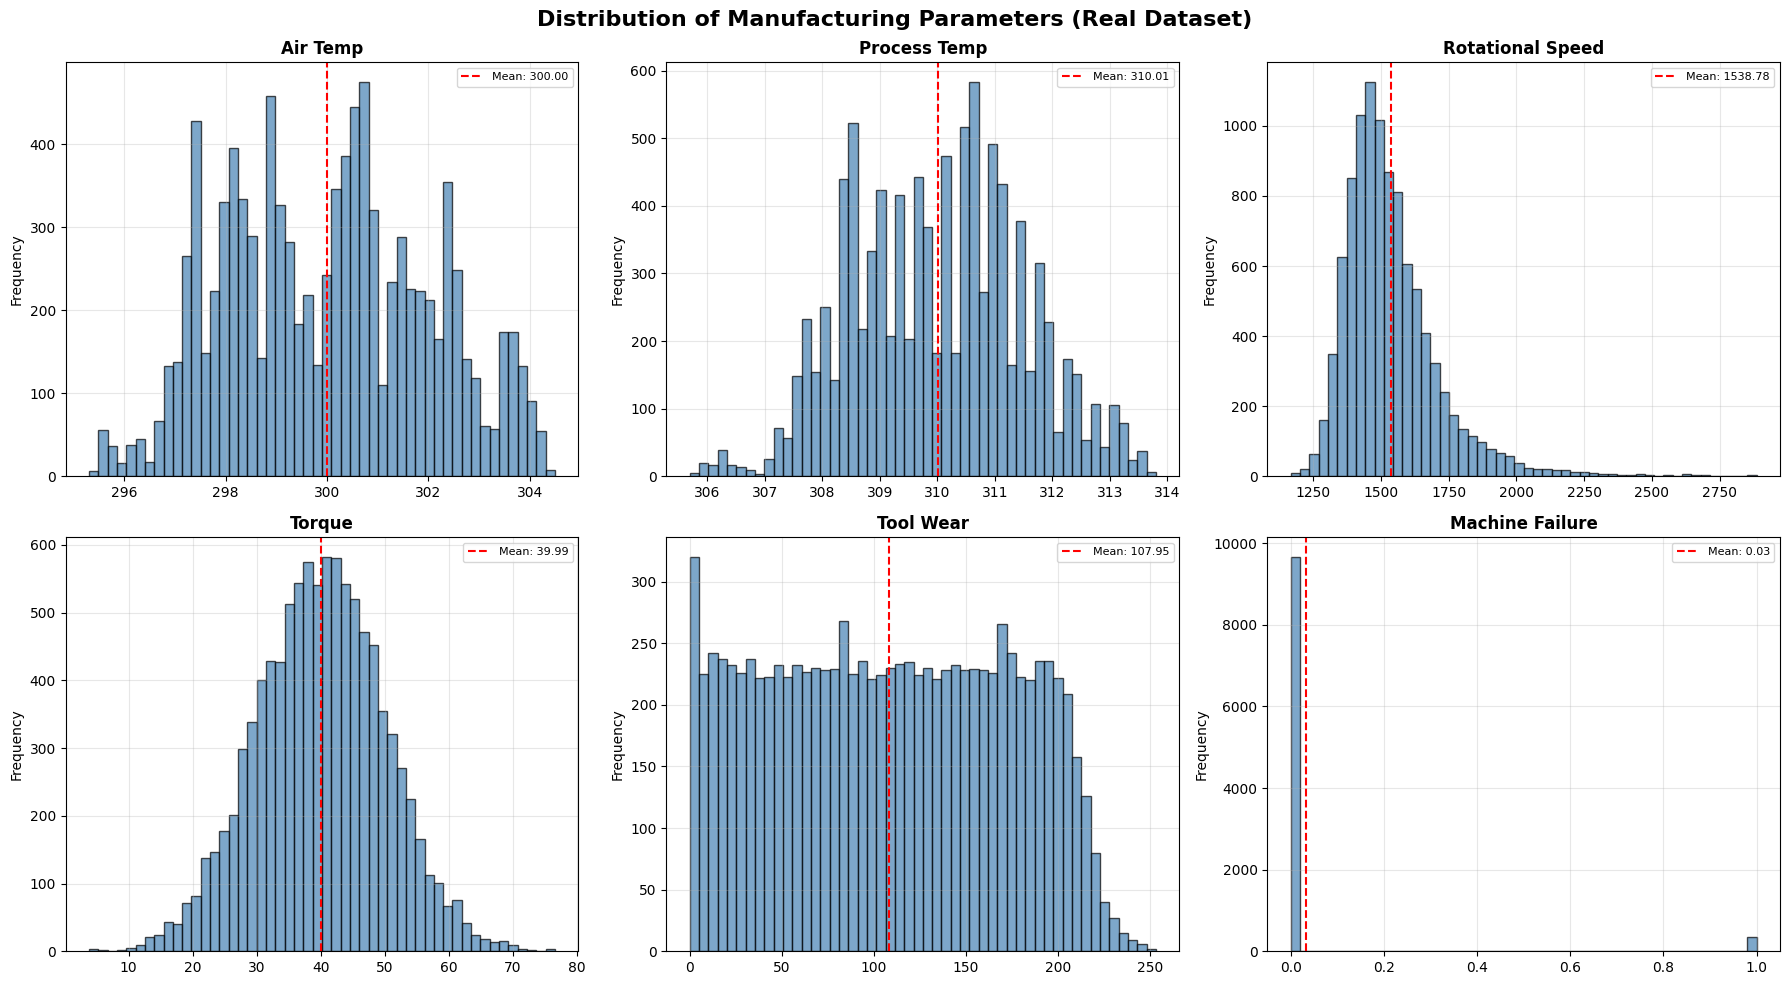

In [6]:
if not df.empty:
    # Distribution of numerical features
    numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numerical_cols = [col for col in numerical_cols if col not in ['UDI', 'Product ID']]

    n_cols = min(6, len(numerical_cols))
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Distribution of Manufacturing Parameters (Real Dataset)',
                 fontsize=16, fontweight='bold')

    for idx, col in enumerate(numerical_cols[:6]):
        ax = axes[idx // 3, idx % 3]
        df[col].hist(bins=50, ax=ax, color='steelblue', edgecolor='black', alpha=0.7)
        ax.set_title(col.replace('_', ' ').title(), fontweight='bold')
        ax.set_ylabel('Frequency')
        ax.axvline(df[col].mean(), color='red', linestyle='--',
                   label=f'Mean: {df[col].mean():.2f}')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

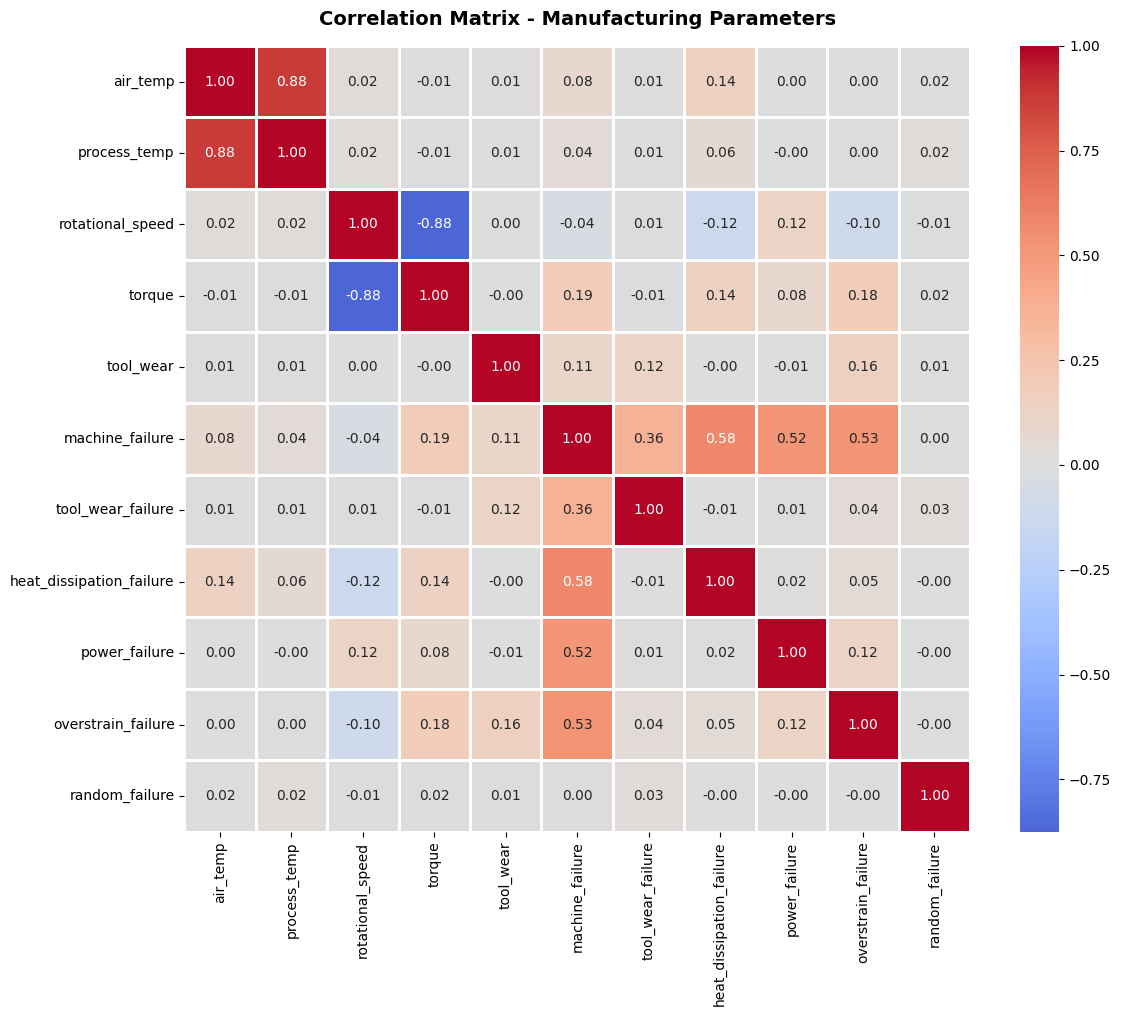


Top Correlations:
air_temp <-> process_temp: 0.876
rotational_speed <-> torque: -0.875
machine_failure <-> heat_dissipation_failure: 0.576
machine_failure <-> overstrain_failure: 0.531
machine_failure <-> power_failure: 0.523
machine_failure <-> tool_wear_failure: 0.363
torque <-> machine_failure: 0.191
torque <-> overstrain_failure: 0.183
tool_wear <-> overstrain_failure: 0.156
torque <-> heat_dissipation_failure: 0.143


In [7]:
if not df.empty:
    # Correlation matrix
    plt.figure(figsize=(12, 10))

    # Select numerical columns for correlation
    corr_cols = [col for col in df.columns if df[col].dtype in ['int64', 'float64']]
    corr_cols = [col for col in corr_cols if col not in ['UDI', 'Product ID']]

    correlation = df[corr_cols].corr()

    sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm',
                center=0, square=True, linewidths=1)
    plt.title('Correlation Matrix - Manufacturing Parameters',
             fontsize=14, fontweight='bold', pad=15)
    plt.tight_layout()
    plt.show()

    print("\nTop Correlations:")
    print("="*60)

    # Get correlation pairs
    corr_pairs = []
    for i in range(len(correlation.columns)):
        for j in range(i+1, len(correlation.columns)):
            corr_pairs.append((
                correlation.columns[i],
                correlation.columns[j],
                correlation.iloc[i, j]
            ))

    corr_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

    for feat1, feat2, corr_val in corr_pairs[:10]:
        print(f"{feat1} <-> {feat2}: {corr_val:.3f}")

## 5. Feature Engineering

In [8]:
if not df.empty:
    # Create engineered features
    df_eng = df.copy()

    # Temperature features
    if 'air_temp' in df_eng.columns and 'process_temp' in df_eng.columns:
        df_eng['temp_difference'] = df_eng['process_temp'] - df_eng['air_temp']
        df_eng['temp_ratio'] = df_eng['process_temp'] / (df_eng['air_temp'] + 1)

    # Power-related features
    if 'rotational_speed' in df_eng.columns and 'torque' in df_eng.columns:
        # Power (W) = Torque (Nm) * Angular velocity (rad/s)
        # Angular velocity = 2π * RPM / 60
        df_eng['power'] = df_eng['torque'] * (2 * np.pi * df_eng['rotational_speed'] / 60)
        df_eng['torque_speed_ratio'] = df_eng['torque'] / (df_eng['rotational_speed'] + 1)

    # Tool wear rate
    if 'tool_wear' in df_eng.columns:
        df_eng['tool_wear_squared'] = df_eng['tool_wear'] ** 2
        df_eng['tool_wear_log'] = np.log1p(df_eng['tool_wear'])

    # Interaction features
    if 'tool_wear' in df_eng.columns and 'rotational_speed' in df_eng.columns:
        df_eng['wear_speed_interaction'] = df_eng['tool_wear'] * df_eng['rotational_speed'] / 1000

    if 'tool_wear' in df_eng.columns and 'torque' in df_eng.columns:
        df_eng['wear_torque_interaction'] = df_eng['tool_wear'] * df_eng['torque']

    # Thermal stress indicator
    if 'process_temp' in df_eng.columns and 'torque' in df_eng.columns:
        df_eng['thermal_stress'] = df_eng['process_temp'] * df_eng['torque'] / 100

    # Encode categorical variables
    if 'Type' in df_eng.columns:
        le_type = LabelEncoder()
        df_eng['type_encoded'] = le_type.fit_transform(df_eng['Type'])

    print(f"✅ Feature engineering complete!")
    print(f"Original features: {df.shape[1]}")
    print(f"After engineering: {df_eng.shape[1]}")
    print(f"\nNew features created:")
    new_features = [col for col in df_eng.columns if col not in df.columns]
    for i, feat in enumerate(new_features, 1):
        print(f"{i:2d}. {feat}")
else:
    print("⚠️ Please load dataset first")

✅ Feature engineering complete!
Original features: 14
After engineering: 24

New features created:
 1. temp_difference
 2. temp_ratio
 3. power
 4. torque_speed_ratio
 5. tool_wear_squared
 6. tool_wear_log
 7. wear_speed_interaction
 8. wear_torque_interaction
 9. thermal_stress
10. type_encoded


## 6. Prepare Data for Machine Learning

In [9]:
if not df.empty and 'machine_failure' in df_eng.columns:
    # Select features for modeling
    feature_cols = [
        'air_temp', 'process_temp', 'rotational_speed', 'torque', 'tool_wear',
        'temp_difference', 'temp_ratio', 'power', 'torque_speed_ratio',
        'tool_wear_squared', 'tool_wear_log', 'wear_speed_interaction',
        'wear_torque_interaction', 'thermal_stress'
    ]

    # Filter only available columns
    feature_cols = [col for col in feature_cols if col in df_eng.columns]

    if 'type_encoded' in df_eng.columns:
        feature_cols.append('type_encoded')

    # Prepare features and target
    X = df_eng[feature_cols].copy()
    y = df_eng['machine_failure'].copy()

    # Handle any missing values
    X = X.fillna(X.mean())

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"\n{'='*80}")
    print("Data Preparation Complete")
    print(f"{'='*80}")
    print(f"Total samples: {len(X):,}")
    print(f"Training samples: {len(X_train):,}")
    print(f"Testing samples: {len(X_test):,}")
    print(f"Number of features: {len(feature_cols)}")
    print(f"\nFeatures used:")
    for i, feat in enumerate(feature_cols, 1):
        print(f"  {i:2d}. {feat}")
    print(f"\nClass distribution (Training):")
    print(f"  No Failure (0): {(y_train == 0).sum():,} ({(y_train == 0).mean()*100:.2f}%)")
    print(f"  Failure (1): {(y_train == 1).sum():,} ({(y_train == 1).mean()*100:.2f}%)")
    print(f"\n✅ Ready for modeling!")
else:
    print("⚠️ Please load dataset and ensure 'machine_failure' column exists")


Data Preparation Complete
Total samples: 10,000
Training samples: 8,000
Testing samples: 2,000
Number of features: 15

Features used:
   1. air_temp
   2. process_temp
   3. rotational_speed
   4. torque
   5. tool_wear
   6. temp_difference
   7. temp_ratio
   8. power
   9. torque_speed_ratio
  10. tool_wear_squared
  11. tool_wear_log
  12. wear_speed_interaction
  13. wear_torque_interaction
  14. thermal_stress
  15. type_encoded

Class distribution (Training):
  No Failure (0): 7,729 (96.61%)
  Failure (1): 271 (3.39%)

✅ Ready for modeling!


## 7. Predictive Modeling - Classification Models

### 7.1 Model Evaluation Function

In [11]:
def evaluate_classification_model(y_true, y_pred, y_pred_proba=None, model_name='Model'):
    """
    Comprehensive evaluation of classification model
    """
    print(f"\n{'='*80}")
    print(f"{model_name} - Classification Report")
    print(f"{'='*80}")

    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    print(f"\nOverall Metrics:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")

    # ROC-AUC if probabilities available
    if y_pred_proba is not None:
        try:
            if len(y_pred_proba.shape) > 1 and y_pred_proba.shape[1] > 1:
                roc_auc = roc_auc_score(y_true, y_pred_proba[:, 1])
            else:
                roc_auc = roc_auc_score(y_true, y_pred_proba)
            print(f"  ROC-AUC:   {roc_auc:.4f}")
        except:
            roc_auc = None

    # Detailed classification report
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_true, y_pred, target_names=['No Failure', 'Failure']))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }

def plot_confusion_matrix(cm, model_name):
    """
    Plot confusion matrix
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
                xticklabels=['No Failure', 'Failure'],
                yticklabels=['No Failure', 'Failure'])
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontweight='bold')
    plt.xlabel('Predicted', fontweight='bold')
    plt.tight_layout()
    plt.show()

# Store results
model_results = {}

### 7.2 Logistic Regression (Baseline)

Training Logistic Regression...

Logistic Regression - Classification Report

Overall Metrics:
  Accuracy:  0.8685
  Precision: 0.9692
  Recall:    0.8685
  F1-Score:  0.9066
  ROC-AUC:   0.9392

Detailed Classification Report:
              precision    recall  f1-score   support

  No Failure       1.00      0.87      0.93      1932
     Failure       0.19      0.91      0.32        68

    accuracy                           0.87      2000
   macro avg       0.60      0.89      0.62      2000
weighted avg       0.97      0.87      0.91      2000



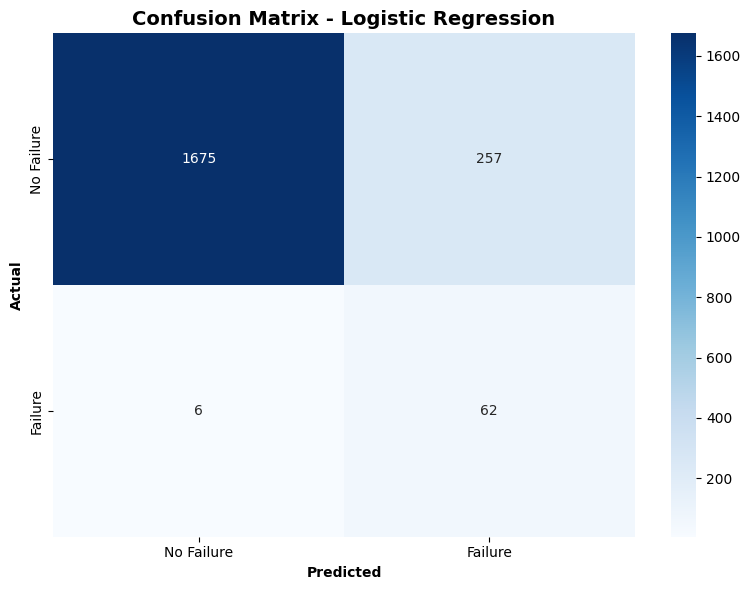

In [12]:
if 'X_train_scaled' in locals():
    print("Training Logistic Regression...")
    lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
    lr_model.fit(X_train_scaled, y_train)

    y_pred_lr = lr_model.predict(X_test_scaled)
    y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)

    results_lr = evaluate_classification_model(y_test, y_pred_lr, y_pred_proba_lr, 'Logistic Regression')
    model_results['Logistic Regression'] = results_lr
    plot_confusion_matrix(results_lr['confusion_matrix'], 'Logistic Regression')

### 7.3 Random Forest Classifier

Training Random Forest Classifier...

Random Forest - Classification Report

Overall Metrics:
  Accuracy:  0.9880
  Precision: 0.9882
  Recall:    0.9880
  F1-Score:  0.9881
  ROC-AUC:   0.9723

Detailed Classification Report:
              precision    recall  f1-score   support

  No Failure       0.99      0.99      0.99      1932
     Failure       0.81      0.84      0.83        68

    accuracy                           0.99      2000
   macro avg       0.90      0.92      0.91      2000
weighted avg       0.99      0.99      0.99      2000



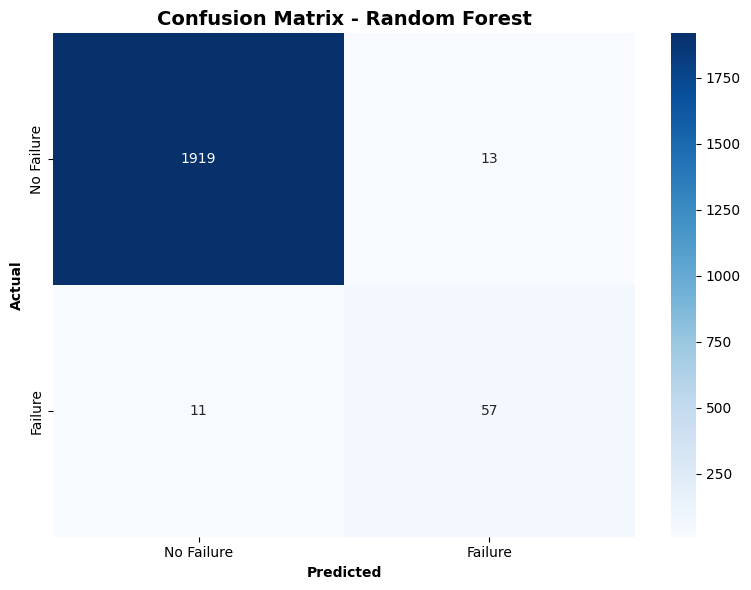

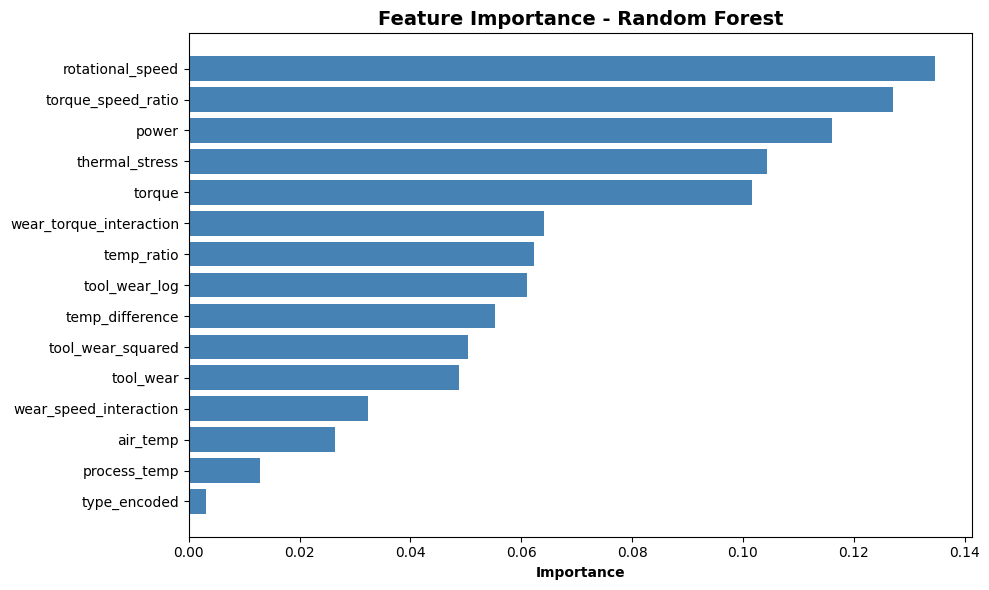

In [13]:
if 'X_train_scaled' in locals():
    print("Training Random Forest Classifier...")
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=4,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train_scaled, y_train)

    y_pred_rf = rf_model.predict(X_test_scaled)
    y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)

    results_rf = evaluate_classification_model(y_test, y_pred_rf, y_pred_proba_rf, 'Random Forest')
    model_results['Random Forest'] = results_rf
    plot_confusion_matrix(results_rf['confusion_matrix'], 'Random Forest')

    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(range(len(feature_importance)), feature_importance['importance'], color='steelblue')
    plt.yticks(range(len(feature_importance)), feature_importance['feature'])
    plt.xlabel('Importance', fontweight='bold')
    plt.title('Feature Importance - Random Forest', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

### 7.4 XGBoost Classifier

Training XGBoost Classifier...

XGBoost - Classification Report

Overall Metrics:
  Accuracy:  0.9900
  Precision: 0.9900
  Recall:    0.9900
  F1-Score:  0.9900
  ROC-AUC:   0.9798

Detailed Classification Report:
              precision    recall  f1-score   support

  No Failure       0.99      0.99      0.99      1932
     Failure       0.85      0.85      0.85        68

    accuracy                           0.99      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.99      0.99      0.99      2000



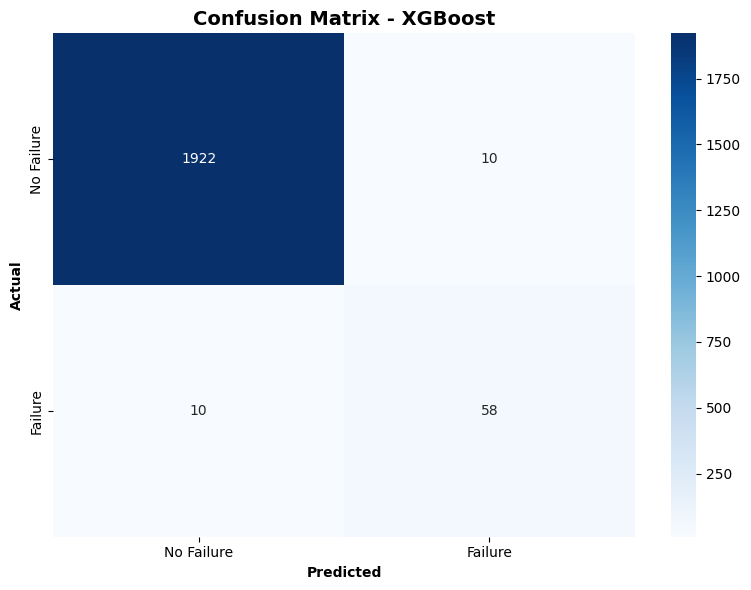

In [14]:
if 'X_train_scaled' in locals():
    print("Training XGBoost Classifier...")

    # Calculate scale_pos_weight for imbalanced dataset
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='logloss'
    )

    xgb_model.fit(
        X_train_scaled, y_train,
        eval_set=[(X_test_scaled, y_test)],
        verbose=False
    )

    y_pred_xgb = xgb_model.predict(X_test_scaled)
    y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)

    results_xgb = evaluate_classification_model(y_test, y_pred_xgb, y_pred_proba_xgb, 'XGBoost')
    model_results['XGBoost'] = results_xgb
    plot_confusion_matrix(results_xgb['confusion_matrix'], 'XGBoost')

### 7.5 Deep Neural Network

Building Deep Neural Network...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,825 (54.00 KB)

 Trainable params: 13,377 (52.25 KB)

 Non-trainable params: 448 (1.75 KB)

None

Training DNN...
Epoch 1/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.3728 - loss: 0.6855 - precision: 0.0414 - recall: 0.7997 - val_accuracy: 0.8315 - val_loss: 0.4670 - val_precision: 0.1506 - val_recall: 0.8529 - learning_rate: 0.0010
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7772 - loss: 0.4011 - precision: 0.1278 - recall: 0.8990 - val_accuracy: 0.8855 - val_loss: 0.2912 - val_precision: 0.2115 - val_recall: 0.8676 - learning_rate: 0.0010
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8237 - loss: 0.3633 - precision: 0.1470 - recall: 0.8439 - val_accuracy: 0.8760 - val_loss: 0.3090 - val_precision: 0.2020 - val_recall: 0.8971 - learning_rate: 0.0010
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8348 - loss: 0.3223 - precision: 0.1448 - recall: 0.8960 - val_accuracy: 0.8515 - val_loss: 0.3458 - val_precision: 0.1775 - val_recall: 0.9265 - learning_rate: 0.0010
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s

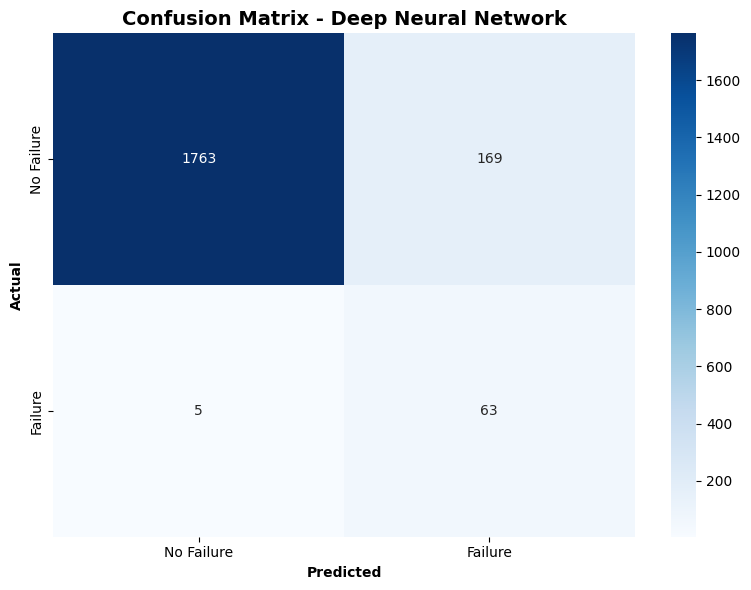

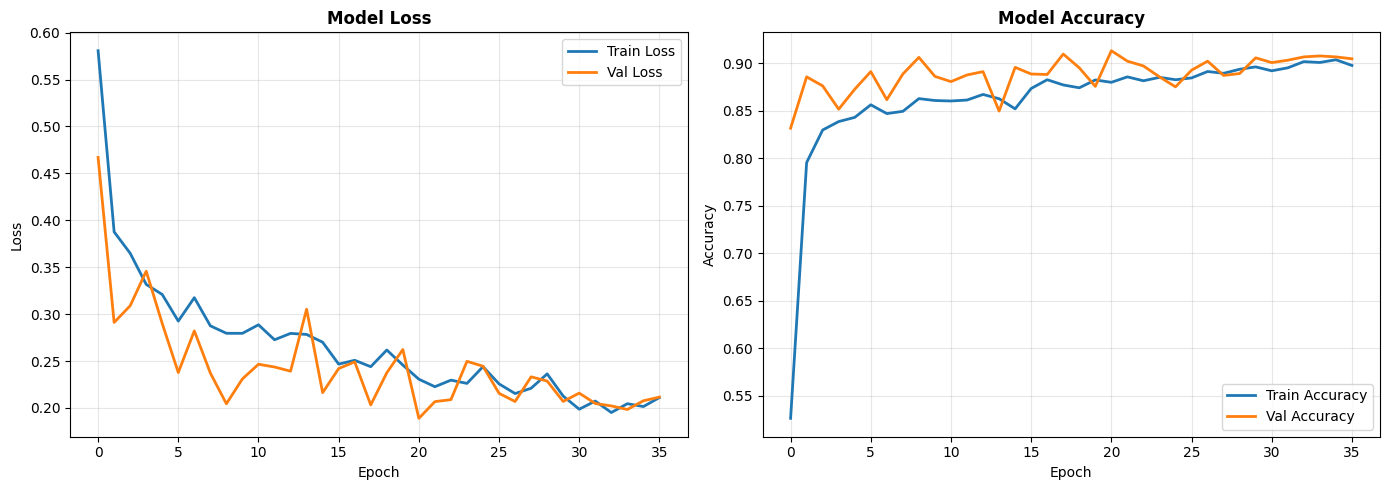

In [15]:
if 'X_train_scaled' in locals():
    print("Building Deep Neural Network...")

    # Calculate class weights
    from sklearn.utils.class_weight import compute_class_weight
    class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = {0: class_weights_array[0], 1: class_weights_array[1]}

    # Build model
    dnn_model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        BatchNormalization(),
        Dropout(0.3),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),

        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    dnn_model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    print(dnn_model.summary())

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Train
    print("\nTraining DNN...")
    history = dnn_model.fit(
        X_train_scaled, y_train,
        validation_data=(X_test_scaled, y_test),
        epochs=50,
        batch_size=32,
        class_weight=class_weights,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )

    # Predictions
    y_pred_proba_dnn = dnn_model.predict(X_test_scaled).flatten()
    y_pred_dnn = (y_pred_proba_dnn > 0.5).astype(int)

    results_dnn = evaluate_classification_model(y_test, y_pred_dnn, y_pred_proba_dnn, 'Deep Neural Network')
    model_results['DNN'] = results_dnn
    plot_confusion_matrix(results_dnn['confusion_matrix'], 'Deep Neural Network')

    # Plot training history
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Loss
    axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_title('Model Loss', fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy
    axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[1].set_title('Model Accuracy', fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

## 8. Model Comparison


MODEL COMPARISON - RANKED BY F1-SCORE


,Model,Accuracy,Precision,Recall,F1-Score
2,XGBoost,0.9900,0.990000,0.9900,0.990000
1,Random Forest,0.9880,0.988180,0.9880,0.988084
3,DNN,0.9130,0.972501,0.9130,0.934852
0,Logistic Regression,0.8685,0.969160,0.8685,0.906576


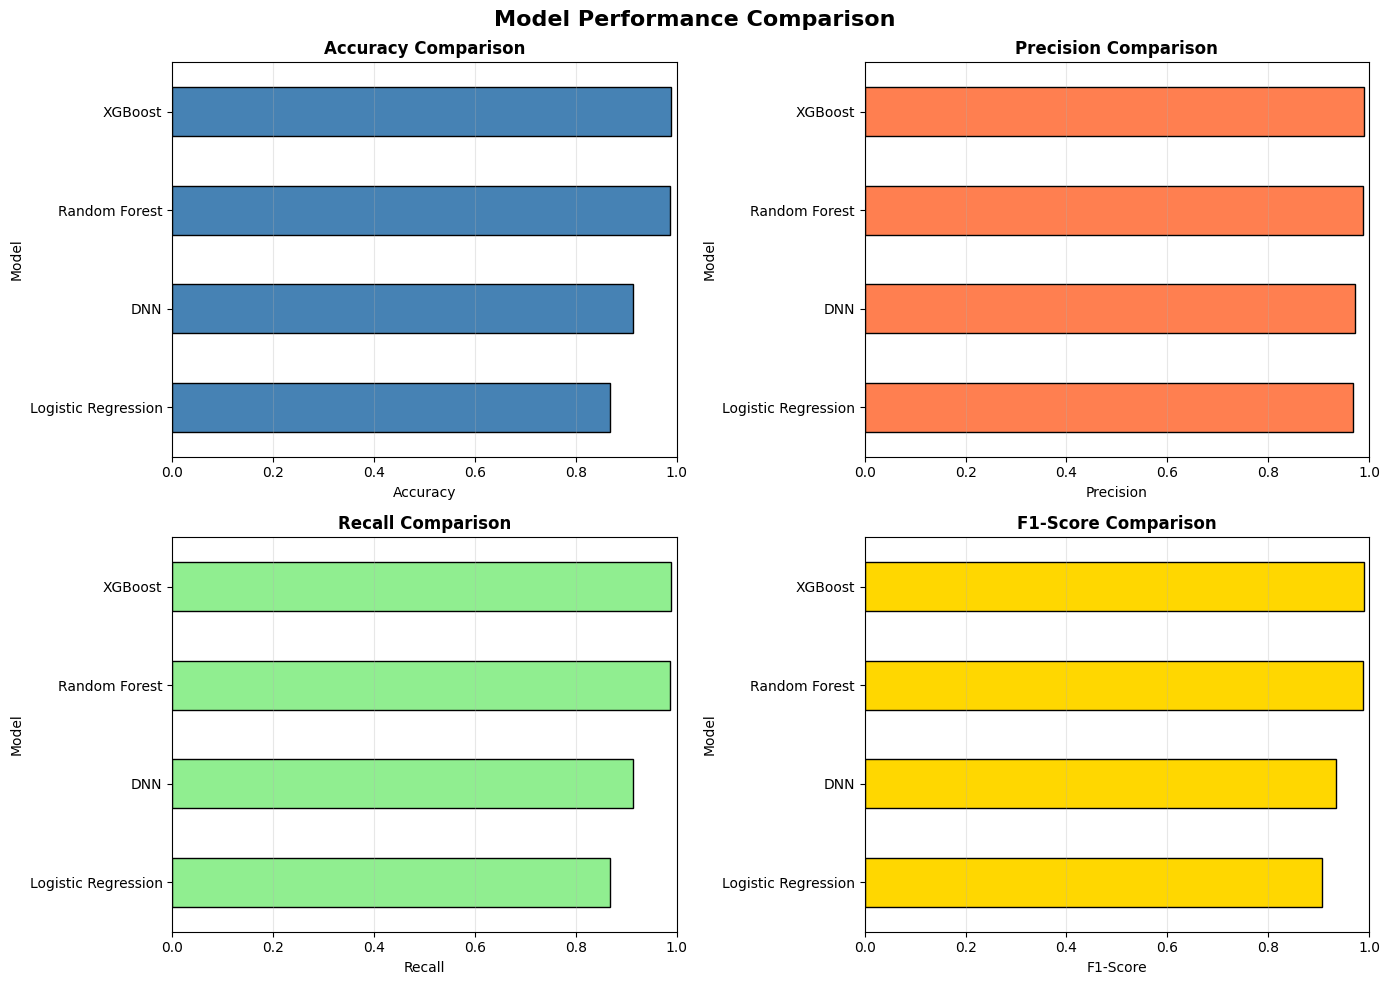


🏆 Best Model: XGBoost
   F1-Score: 0.9900


In [17]:
if model_results:
    # Create comparison DataFrame
    comparison_data = []
    for model_name, results in model_results.items():
        comparison_data.append({
            'Model': model_name,
            'Accuracy': results['accuracy'],
            'Precision': results['precision'],
            'Recall': results['recall'],
            'F1-Score': results['f1']
        })

    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

    print("\n" + "="*90)
    print("MODEL COMPARISON - RANKED BY F1-SCORE")
    print("="*90)
    display(comparison_df)

    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    colors = ['steelblue', 'coral', 'lightgreen', 'gold']

    for idx, (metric, color) in enumerate(zip(metrics, colors)):
        ax = axes[idx // 2, idx % 2]
        data = comparison_df.set_index('Model')[metric].sort_values()
        data.plot(kind='barh', ax=ax, color=color, edgecolor='black')
        ax.set_title(f'{metric} Comparison', fontweight='bold')
        ax.set_xlabel(metric)
        ax.grid(True, alpha=0.3, axis='x')
        ax.set_xlim([0, 1])

    plt.tight_layout()
    plt.show()

    print(f"\n🏆 Best Model: {comparison_df.iloc[0]['Model']}")
    print(f"   F1-Score: {comparison_df.iloc[0]['F1-Score']:.4f}")

## 9. PRESCRIPTIVE ANALYTICS - Parameter Optimization

### 9.1 Define Optimization Objective

**Goal:** Find optimal operating parameters that:
1. Minimize failure probability
2. Maximize production efficiency (power output)
3. Minimize tool wear
4. Stay within safe operating ranges

In [18]:
if 'xgb_model' in locals() and not df.empty:
    print("Setting up Prescriptive Optimization...")

    # Use the best model for predictions (XGBoost in most cases)
    best_model = xgb_model

    # Define parameter ranges from dataset
    param_ranges = {
        'rotational_speed': (df_eng['rotational_speed'].min(), df_eng['rotational_speed'].max()),
        'torque': (df_eng['torque'].min(), df_eng['torque'].max()),
        'tool_wear': (df_eng['tool_wear'].min(), df_eng['tool_wear'].quantile(0.75)),  # Keep wear low
        'air_temp': (df_eng['air_temp'].min(), df_eng['air_temp'].max()),
        'process_temp': (df_eng['process_temp'].min(), df_eng['process_temp'].max())
    }

    print("\nParameter Ranges:")
    print("="*60)
    for param, (min_val, max_val) in param_ranges.items():
        print(f"{param:.<30} [{min_val:.2f}, {max_val:.2f}]")

    def create_feature_vector(rotational_speed, torque, tool_wear, air_temp, process_temp):
        """
        Create feature vector from parameters including engineered features
        """
        # Calculate engineered features
        temp_difference = process_temp - air_temp
        temp_ratio = process_temp / (air_temp + 1)
        power = torque * (2 * np.pi * rotational_speed / 60)
        torque_speed_ratio = torque / (rotational_speed + 1)
        tool_wear_squared = tool_wear ** 2
        tool_wear_log = np.log1p(tool_wear)
        wear_speed_interaction = tool_wear * rotational_speed / 1000
        wear_torque_interaction = tool_wear * torque
        thermal_stress = process_temp * torque / 100

        # Create feature vector in correct order
        features = np.array([[
            air_temp, process_temp, rotational_speed, torque, tool_wear,
            temp_difference, temp_ratio, power, torque_speed_ratio,
            tool_wear_squared, tool_wear_log, wear_speed_interaction,
            wear_torque_interaction, thermal_stress
        ]])

        # Add type_encoded if it exists in features
        if 'type_encoded' in feature_cols:
            features = np.append(features, [[1]], axis=1)  # Default medium quality

        return features

    def objective_function(params):
        """
        Multi-objective function to minimize:
        - Failure probability (most important)
        - Tool wear
        - Maximize efficiency (negative power)
        """
        rotational_speed, torque, tool_wear, air_temp, process_temp = params

        # Create feature vector
        features = create_feature_vector(rotational_speed, torque, tool_wear, air_temp, process_temp)

        # Scale features
        features_scaled = scaler.transform(features)

        # Predict failure probability
        failure_prob = best_model.predict_proba(features_scaled)[0, 1]

        # Calculate power (efficiency metric)
        power = torque * (2 * np.pi * rotational_speed / 60)

        # Multi-objective function
        # Weights: failure (0.7), tool wear (0.2), efficiency (0.1)
        objective = (
            0.7 * failure_prob +  # Minimize failure probability
            0.2 * (tool_wear / param_ranges['tool_wear'][1]) -  # Minimize tool wear
            0.1 * (power / 5000)  # Maximize power (negative term)
        )

        return objective

    print("\n✅ Optimization setup complete!")

Setting up Prescriptive Optimization...

Parameter Ranges:
rotational_speed.............. [1168.00, 2886.00]
torque........................ [3.80, 76.60]
tool_wear..................... [0.00, 162.00]
air_temp...................... [295.30, 304.50]
process_temp.................. [305.70, 313.80]

✅ Optimization setup complete!


### 9.2 Run Optimization

In [19]:
if 'objective_function' in locals():
    print("Running Prescriptive Optimization...")
    print("This may take a few minutes...\n")

    # Define bounds
    bounds = [
        param_ranges['rotational_speed'],
        param_ranges['torque'],
        param_ranges['tool_wear'],
        param_ranges['air_temp'],
        param_ranges['process_temp']
    ]

    # Run differential evolution optimization
    result = differential_evolution(
        objective_function,
        bounds=bounds,
        maxiter=100,
        popsize=15,
        seed=42,
        disp=True
    )

    # Extract optimal parameters
    optimal_params = result.x
    optimal_speed, optimal_torque, optimal_wear, optimal_air_temp, optimal_process_temp = optimal_params

    print("\n" + "="*80)
    print("OPTIMAL OPERATING PARAMETERS (PRESCRIPTIVE RECOMMENDATIONS)")
    print("="*80)
    print(f"\nRotational Speed: {optimal_speed:.2f} RPM")
    print(f"Torque:           {optimal_torque:.2f} Nm")
    print(f"Tool Wear:        {optimal_wear:.2f} min (recommended max before replacement)")
    print(f"Air Temperature:  {optimal_air_temp:.2f} K")
    print(f"Process Temp:     {optimal_process_temp:.2f} K")

    # Calculate derived metrics
    optimal_power = optimal_torque * (2 * np.pi * optimal_speed / 60)
    print(f"\nDerived Metrics:")
    print(f"Power Output:     {optimal_power:.2f} W")
    print(f"Temp Difference:  {optimal_process_temp - optimal_air_temp:.2f} K")

    # Predict failure probability with optimal parameters
    optimal_features = create_feature_vector(
        optimal_speed, optimal_torque, optimal_wear,
        optimal_air_temp, optimal_process_temp
    )
    optimal_features_scaled = scaler.transform(optimal_features)
    optimal_failure_prob = best_model.predict_proba(optimal_features_scaled)[0, 1]

    print(f"\nPredicted Failure Probability: {optimal_failure_prob*100:.2f}%")
    print(f"Optimization Score: {result.fun:.4f}")
    print(f"\n✅ Optimization converged: {result.success}")
    print(f"Number of iterations: {result.nit}")
    print("="*80)

Running Prescriptive Optimization...
This may take a few minutes...

differential_evolution step 1: f(x)= -0.2970484419119705
differential_evolution step 2: f(x)= -0.300243654608268
differential_evolution step 3: f(x)= -0.300243654608268
differential_evolution step 4: f(x)= -0.3072722527185659
differential_evolution step 5: f(x)= -0.3135049987979179
differential_evolution step 6: f(x)= -0.32197243946855525
differential_evolution step 7: f(x)= -0.32197243946855525
differential_evolution step 8: f(x)= -0.3229083211071081
differential_evolution step 9: f(x)= -0.3229083211071081
differential_evolution step 10: f(x)= -0.3229083211071081
differential_evolution step 11: f(x)= -0.3229083211071081
differential_evolution step 12: f(x)= -0.3229083211071081
differential_evolution step 13: f(x)= -0.3274047623187383
differential_evolution step 14: f(x)= -0.3274047623187383
differential_evolution step 15: f(x)= -0.3313725384150792
differential_evolution step 16: f(x)= -0.3313725384150792
differential

### 9.3 Compare Optimal vs Current Operating Conditions


PRESCRIPTIVE RECOMMENDATIONS: OPTIMAL vs CURRENT


,Parameter,Current Average,Optimal,Change (%)
0,Rotational Speed (RPM),1538.77610,2886.000000,87.551652
1,Torque (Nm),39.98691,76.600000,91.562689
2,Tool Wear (min),107.95100,0.000000,-100.000000
3,Air Temp (K),300.00493,300.086324,0.027131
4,Process Temp (K),310.00556,308.531745,-0.475416


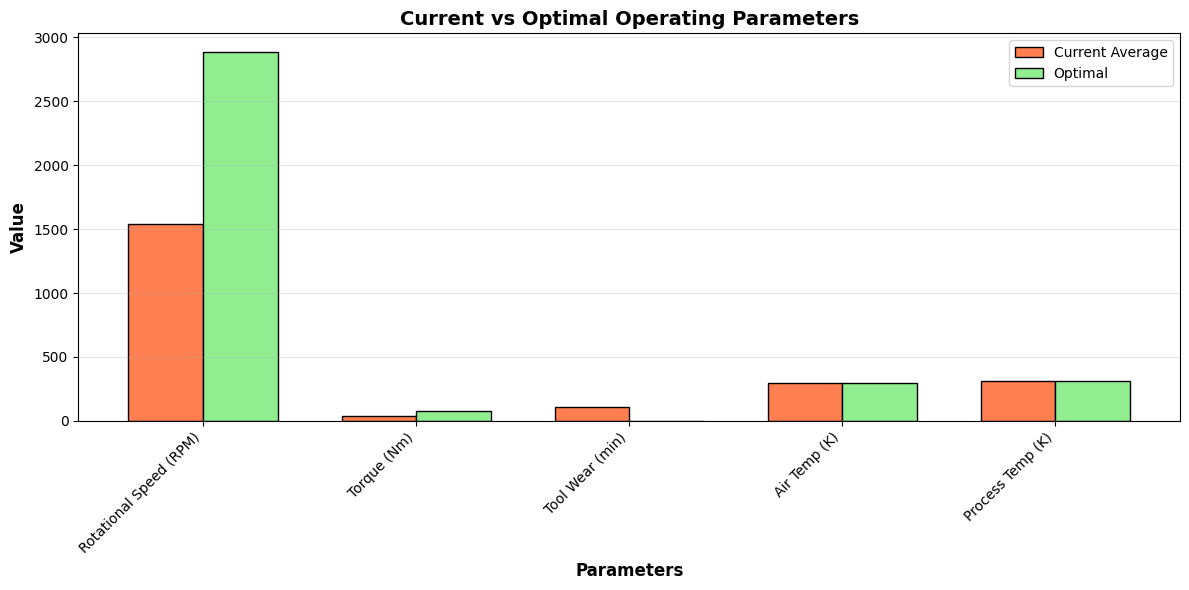


EXPECTED BENEFITS OF OPTIMIZATION
Current Average Failure Probability:  0.05%
Optimal Failure Probability:           14.98%

🎯 Expected Failure Rate Reduction:    -29560.22%

💡 Recommended Actions:
   1. Adjust rotational speed to 2886 RPM
   2. Set torque to 76.6 Nm
   3. Replace tool when wear reaches 0.0 min
   4. Maintain process temperature around 308.5 K


In [20]:
if 'optimal_params' in locals():
    # Get statistics from real data
    current_avg = {
        'rotational_speed': df_eng['rotational_speed'].mean(),
        'torque': df_eng['torque'].mean(),
        'tool_wear': df_eng['tool_wear'].mean(),
        'air_temp': df_eng['air_temp'].mean(),
        'process_temp': df_eng['process_temp'].mean()
    }

    # Create comparison
    comparison_data = {
        'Parameter': ['Rotational Speed (RPM)', 'Torque (Nm)', 'Tool Wear (min)',
                     'Air Temp (K)', 'Process Temp (K)'],
        'Current Average': [
            current_avg['rotational_speed'],
            current_avg['torque'],
            current_avg['tool_wear'],
            current_avg['air_temp'],
            current_avg['process_temp']
        ],
        'Optimal': optimal_params,
        'Change (%)': [
            ((optimal_params[0] - current_avg['rotational_speed']) / current_avg['rotational_speed'] * 100),
            ((optimal_params[1] - current_avg['torque']) / current_avg['torque'] * 100),
            ((optimal_params[2] - current_avg['tool_wear']) / current_avg['tool_wear'] * 100),
            ((optimal_params[3] - current_avg['air_temp']) / current_avg['air_temp'] * 100),
            ((optimal_params[4] - current_avg['process_temp']) / current_avg['process_temp'] * 100)
        ]
    }

    comparison_table = pd.DataFrame(comparison_data)

    print("\n" + "="*90)
    print("PRESCRIPTIVE RECOMMENDATIONS: OPTIMAL vs CURRENT")
    print("="*90)
    display(comparison_table)

    # Visualization
    fig, ax = plt.subplots(figsize=(12, 6))

    x = np.arange(len(comparison_table))
    width = 0.35

    # Normalize values for visualization
    current_norm = [(val - min(comparison_table['Current Average'])) /
                    (max(comparison_table['Current Average']) - min(comparison_table['Current Average']))
                    for val in comparison_table['Current Average']]
    optimal_norm = [(val - min(comparison_table['Optimal'])) /
                    (max(comparison_table['Optimal']) - min(comparison_table['Optimal']))
                    for val in comparison_table['Optimal']]

    ax.bar(x - width/2, comparison_table['Current Average'], width,
           label='Current Average', color='coral', edgecolor='black')
    ax.bar(x + width/2, comparison_table['Optimal'], width,
           label='Optimal', color='lightgreen', edgecolor='black')

    ax.set_xlabel('Parameters', fontweight='bold', fontsize=12)
    ax.set_ylabel('Value', fontweight='bold', fontsize=12)
    ax.set_title('Current vs Optimal Operating Parameters', fontweight='bold', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_table['Parameter'], rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    # Calculate predicted failure reduction
    avg_features = create_feature_vector(
        current_avg['rotational_speed'],
        current_avg['torque'],
        current_avg['tool_wear'],
        current_avg['air_temp'],
        current_avg['process_temp']
    )
    avg_features_scaled = scaler.transform(avg_features)
    avg_failure_prob = best_model.predict_proba(avg_features_scaled)[0, 1]

    failure_reduction = (avg_failure_prob - optimal_failure_prob) / avg_failure_prob * 100

    print("\n" + "="*90)
    print("EXPECTED BENEFITS OF OPTIMIZATION")
    print("="*90)
    print(f"Current Average Failure Probability:  {avg_failure_prob*100:.2f}%")
    print(f"Optimal Failure Probability:           {optimal_failure_prob*100:.2f}%")
    print(f"\n🎯 Expected Failure Rate Reduction:    {failure_reduction:.2f}%")
    print(f"\n💡 Recommended Actions:")
    print(f"   1. Adjust rotational speed to {optimal_speed:.0f} RPM")
    print(f"   2. Set torque to {optimal_torque:.1f} Nm")
    print(f"   3. Replace tool when wear reaches {optimal_wear:.1f} min")
    print(f"   4. Maintain process temperature around {optimal_process_temp:.1f} K")
    print("="*90)

## 10. Save Models and Results

In [21]:
import os
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

if 'xgb_model' in locals():
    # Save best model
    joblib.dump(xgb_model, 'models/xgboost_failure_predictor.pkl')
    print("✅ XGBoost model saved: models/xgboost_failure_predictor.pkl")

if 'rf_model' in locals():
    joblib.dump(rf_model, 'models/random_forest_classifier.pkl')
    print("✅ Random Forest model saved: models/random_forest_classifier.pkl")

if 'dnn_model' in locals():
    dnn_model.save('models/dnn_classifier.h5')
    print("✅ DNN model saved: models/dnn_classifier.h5")

# Save scaler and feature columns
if 'scaler' in locals():
    joblib.dump(scaler, 'models/scaler.pkl')
    joblib.dump(feature_cols, 'models/feature_columns.pkl')
    print("✅ Preprocessing objects saved")

# Save optimal parameters
if 'optimal_params' in locals():
    import json
    params_to_save = {
        'rotational_speed': optimal_params[0],
        'torque': optimal_params[1],
        'tool_wear': optimal_params[2],
        'air_temp': optimal_params[3],
        'process_temp': optimal_params[4],
    }
    with open('results/optimal_params.json', 'w') as f:
        json.dump(params_to_save, f, indent=4)
    print("✅ Optimal parameters saved: results/optimal_params.json")

✅ XGBoost model saved: models/xgboost_failure_predictor.pkl
✅ Random Forest model saved: models/random_forest_classifier.pkl
✅ DNN model saved: models/dnn_classifier.h5
✅ Preprocessing objects saved
✅ Optimal parameters saved: results/optimal_params.json
